# Проект "Анализ вакансий hh.ru"

## Описание

### Цели
1. Получить представление о современных требованиях в анализе данных,
2. Добавить проект получения, подготовки, анализа и визуализации в портфолио.

### Гипотезы
Гипотеза 1: Существует особый "аналитический" язык для описания вакансий,
Гипотеза 2: Технический стек отличается по специальностям (аналитик, финансовый/инвестиционный аналитик, BI-аналитик/аналитик данных, продуктовый аналитик, маркетинговый аналитик)

In [73]:
from re import sub
from pandas import read_excel, DataFrame
import matplotlib
import matplotlib.pyplot as plt
from nltk import tokenize, corpus
from bs4 import BeautifulSoup
from wordcloud import WordCloud

%matplotlib inline

## Чтение данных

Загружаем описание и ключевые навыки в описании вакансии по специальностям. Заполняем пропуски пустой строкой.

In [74]:
analyst_vacancies = read_excel(io='./data/vacancies-10.xlsx', usecols=['description','key_skills'], dtype={
    'description':str,	
    'key_skills':str
}).fillna('')
financial_n_investment_analyst_vacancies = read_excel(io='./data/vacancies-134.xlsx', usecols=['description','key_skills'], dtype={
    'description':str,	
    'key_skills':str
}).fillna('')
bi_n_data_analyst_vacancies = read_excel(io='./data/vacancies-156.xlsx', usecols=['description','key_skills'], dtype={
    'description':str,	
    'key_skills':str
}).fillna('')
marketing_analyst_vacancies = read_excel(io='./data/vacancies-163.xlsx', usecols=['description','key_skills'], dtype={
    'description':str,	
    'key_skills':str
}).fillna('')
product_analyst_vacancies = read_excel(io='./data/vacancies-164.xlsx', usecols=['description','key_skills'], dtype={
    'description':str,	
    'key_skills':str
}).fillna('')

## Очистка данных

В вакансиях встречаются полные дубликаты по описанию, если вакансия размещается на несколько населенных пунктов. Удалим их

In [75]:
analyst_vacancies = analyst_vacancies.drop_duplicates(subset='description', keep="last")
financial_n_investment_analyst_vacancies = financial_n_investment_analyst_vacancies.drop_duplicates(subset='description', keep="last")
bi_n_data_analyst_vacancies = bi_n_data_analyst_vacancies.drop_duplicates(subset='description', keep="last")
product_analyst_vacancies = product_analyst_vacancies.drop_duplicates(subset='description', keep="last")
marketing_analyst_vacancies = marketing_analyst_vacancies.drop_duplicates(subset='description', keep="last")

## Визуализация частоты используемых латинских слов в описании вакансии

Для сравнения очистим описание вакансии от html-разметки и нелатинских символов. На всякий случай удалим стоп-слова и отдельные символы. Объединим описания всех специальностей и выведем для них отдельное изображение. Представим данные в виде облака слов - размер шрифта тем больше, чем чаще встречается слово.

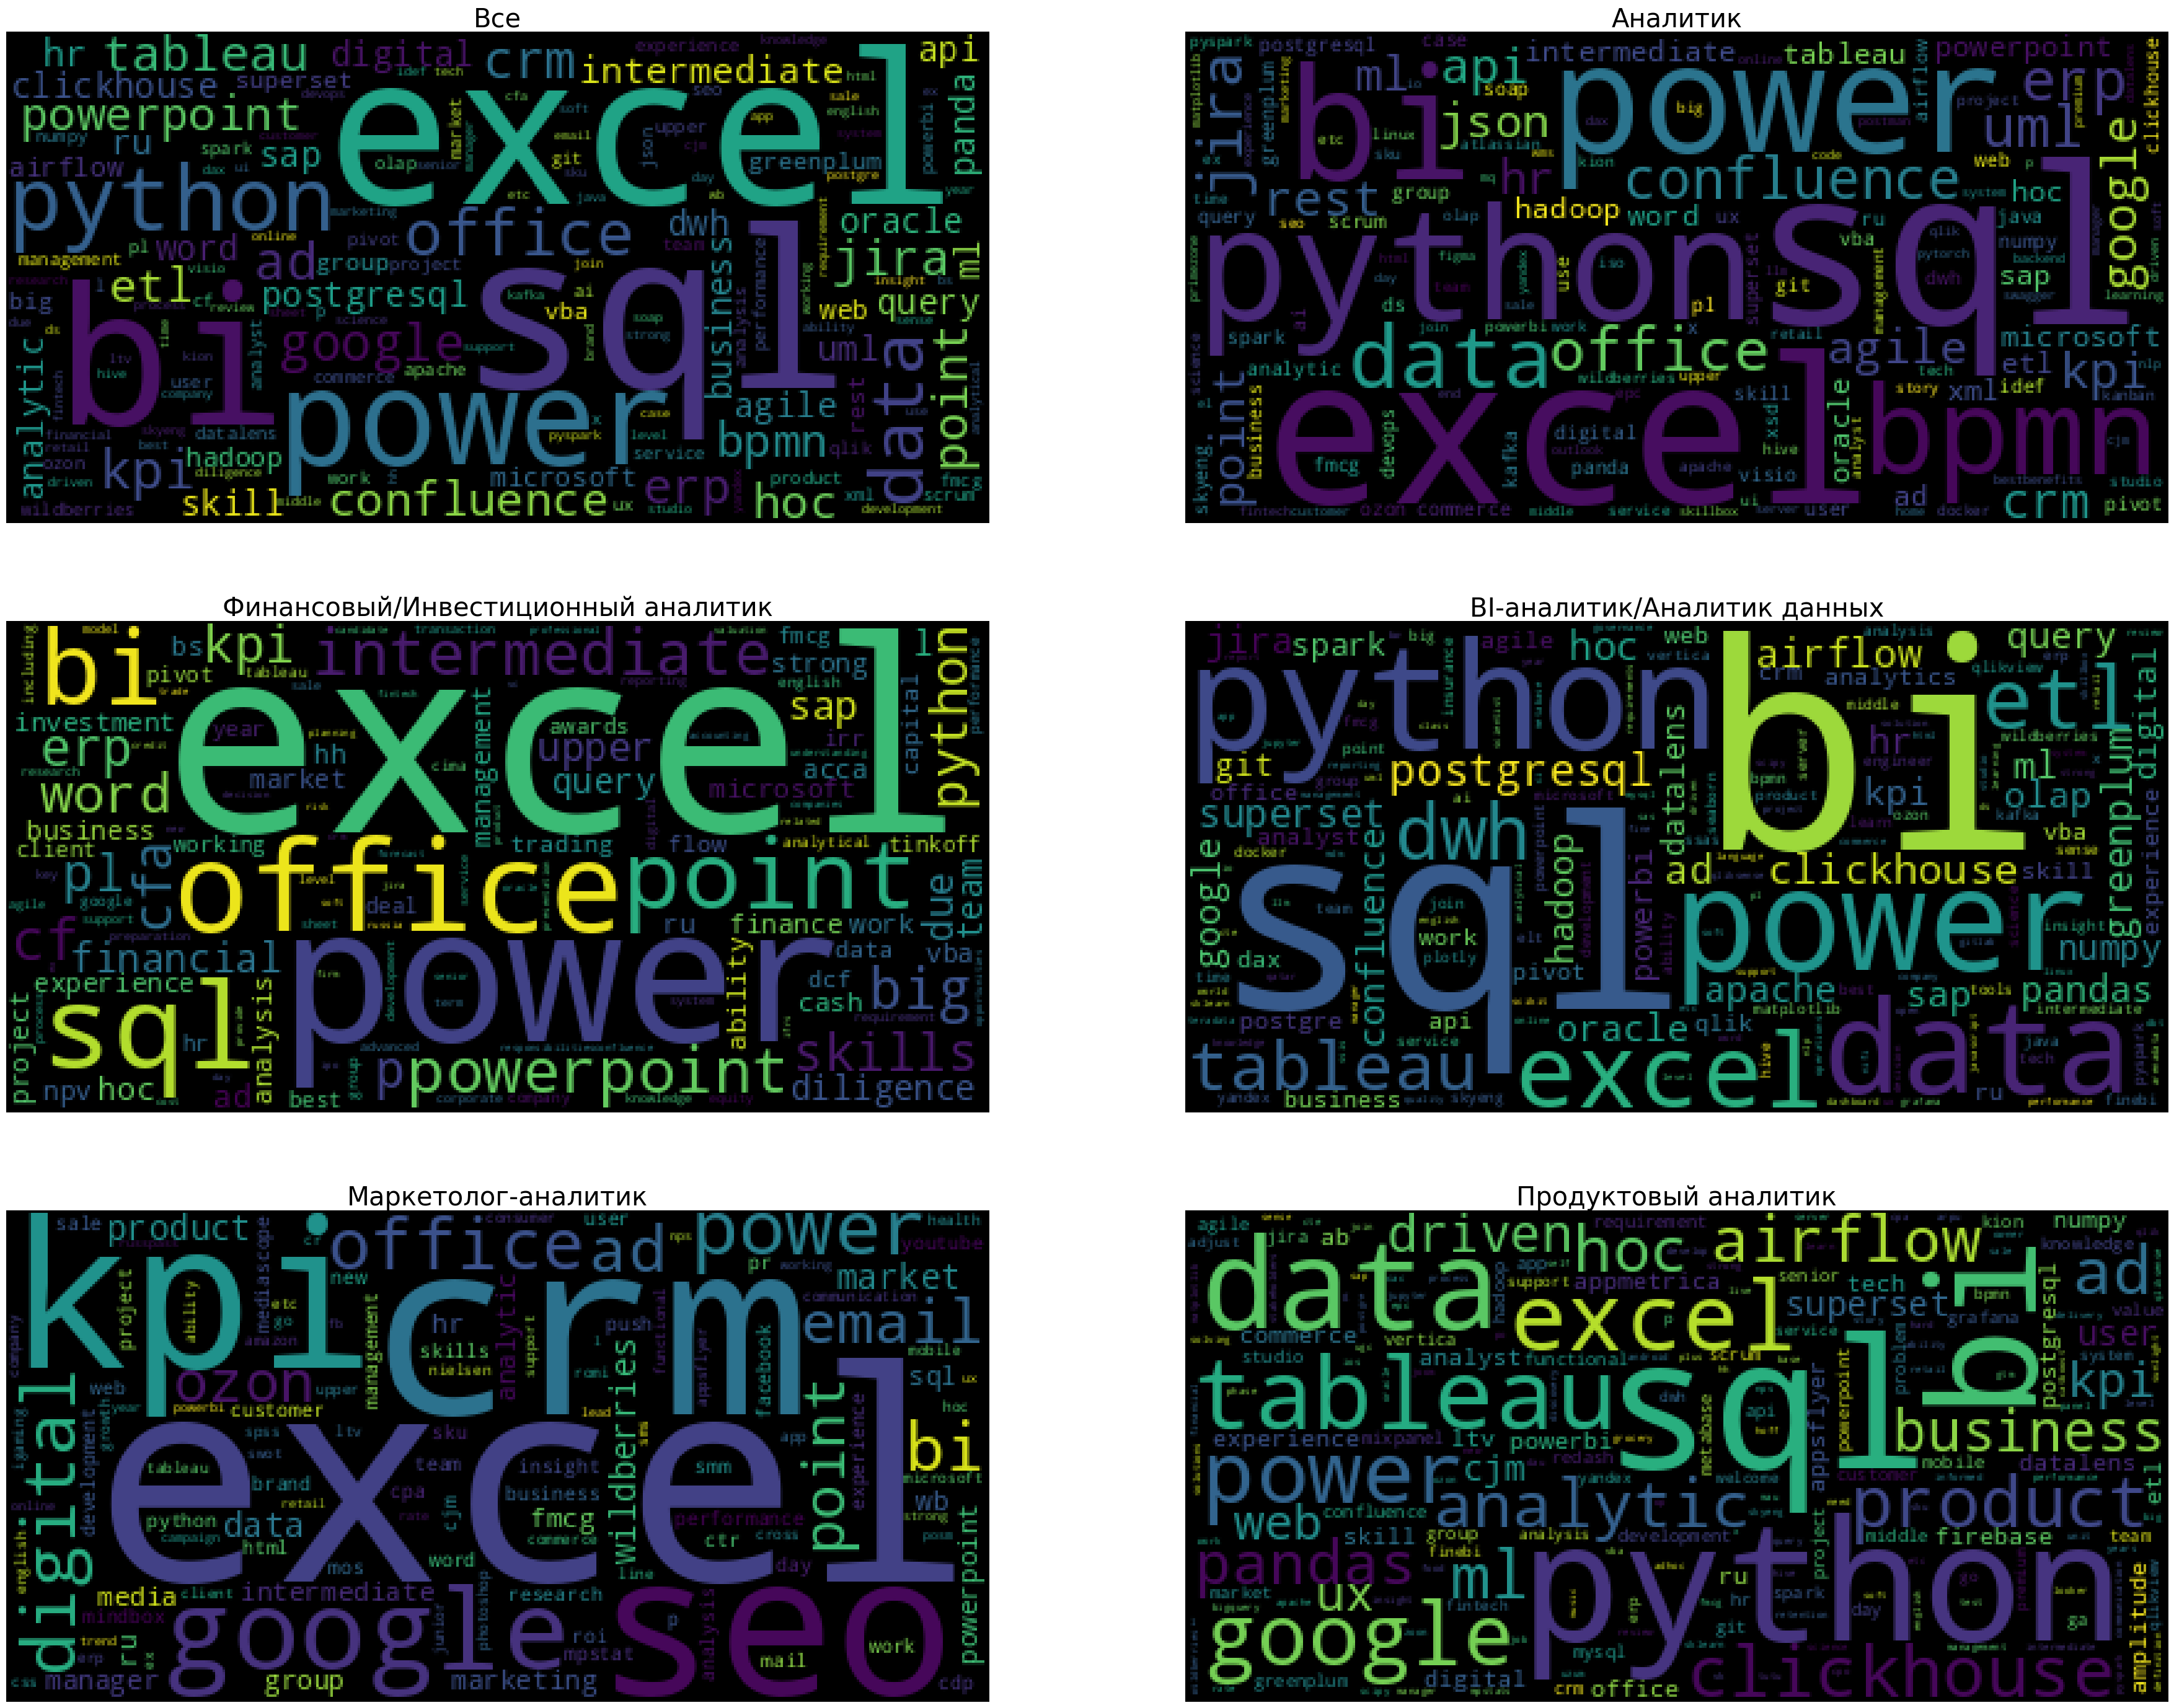

In [76]:
def get_text_for_word_cloud(descriptions):
    demarkuped_description = BeautifulSoup(''.join(descriptions), 'lxml').text.lower()
    latin_n_spaces_description = sub(r'[^\x00-\x7f]|[0-9]|[–·\.,;:!?()-/\%\&\\«»•\+—`\']',r' ', demarkuped_description)
    words = tokenize.word_tokenize(latin_n_spaces_description)
    stopwords_en = corpus.stopwords.words('english')
    cleaned_words = list(w for w in words if w not in stopwords_en and w not in ['a','b','c','d','e','ms'])
    return ' '.join(cleaned_words)

description_cloud_texts = {
    'analyst': get_text_for_word_cloud(analyst_vacancies['description']),
    'financial_n_investment_analyst': get_text_for_word_cloud(financial_n_investment_analyst_vacancies['description']),
    'bi_n_data_analyst': get_text_for_word_cloud(bi_n_data_analyst_vacancies['description']),
    'marketing_analyst': get_text_for_word_cloud(marketing_analyst_vacancies['description']),
    'product_analyst': get_text_for_word_cloud(product_analyst_vacancies['description']),
}

description_collection = [
    {
        'name': 'Все',
        'text': ' '.join([
            description_cloud_texts['analyst'],
            description_cloud_texts['financial_n_investment_analyst'],
            description_cloud_texts['bi_n_data_analyst'],
            description_cloud_texts['marketing_analyst'],
            description_cloud_texts['product_analyst']
        ])
    },
    {
        'name': 'Аналитик',
        'text': description_cloud_texts['analyst']
    },
    {
        'name': 'Финансовый/Инвестиционный аналитик',
        'text': description_cloud_texts['financial_n_investment_analyst']
    },
    {
        'name': 'BI-аналитик/Аналитик данных',
        'text': description_cloud_texts['bi_n_data_analyst']
    },
    {
        'name': 'Маркетолог-аналитик',
        'text': description_cloud_texts['marketing_analyst']
    },
    {
        'name': 'Продуктовый аналитик',
        'text': description_cloud_texts['product_analyst']
    }
]

descriptions_figure = plt.figure(figsize=(45,35))
no_meta_variable = ''
for i, item in enumerate(description_collection):
    description_word_cloud = descriptions_figure.add_subplot(3,2,i+1)
    no_meta_variable = description_word_cloud.axis('off')
    no_meta_variable = description_word_cloud.set_title(item['name'], fontsize=30)
    no_meta_variable = description_word_cloud.imshow(WordCloud(collocations=False).generate(item['text']))

У финансовых, инвестиционных и маркетолог- аналитиков основным инструментом выступает Excel. В остальных преобладают SQL, Python, BI, Excel.

## Визуализация частоты используемых латинских слов в ключевых навыках

Повторим операцию для столбца 'key_skills'. Исключим слова, не имеющие значения или одинаково часто используемые в ключевых навыках всех специальностей.

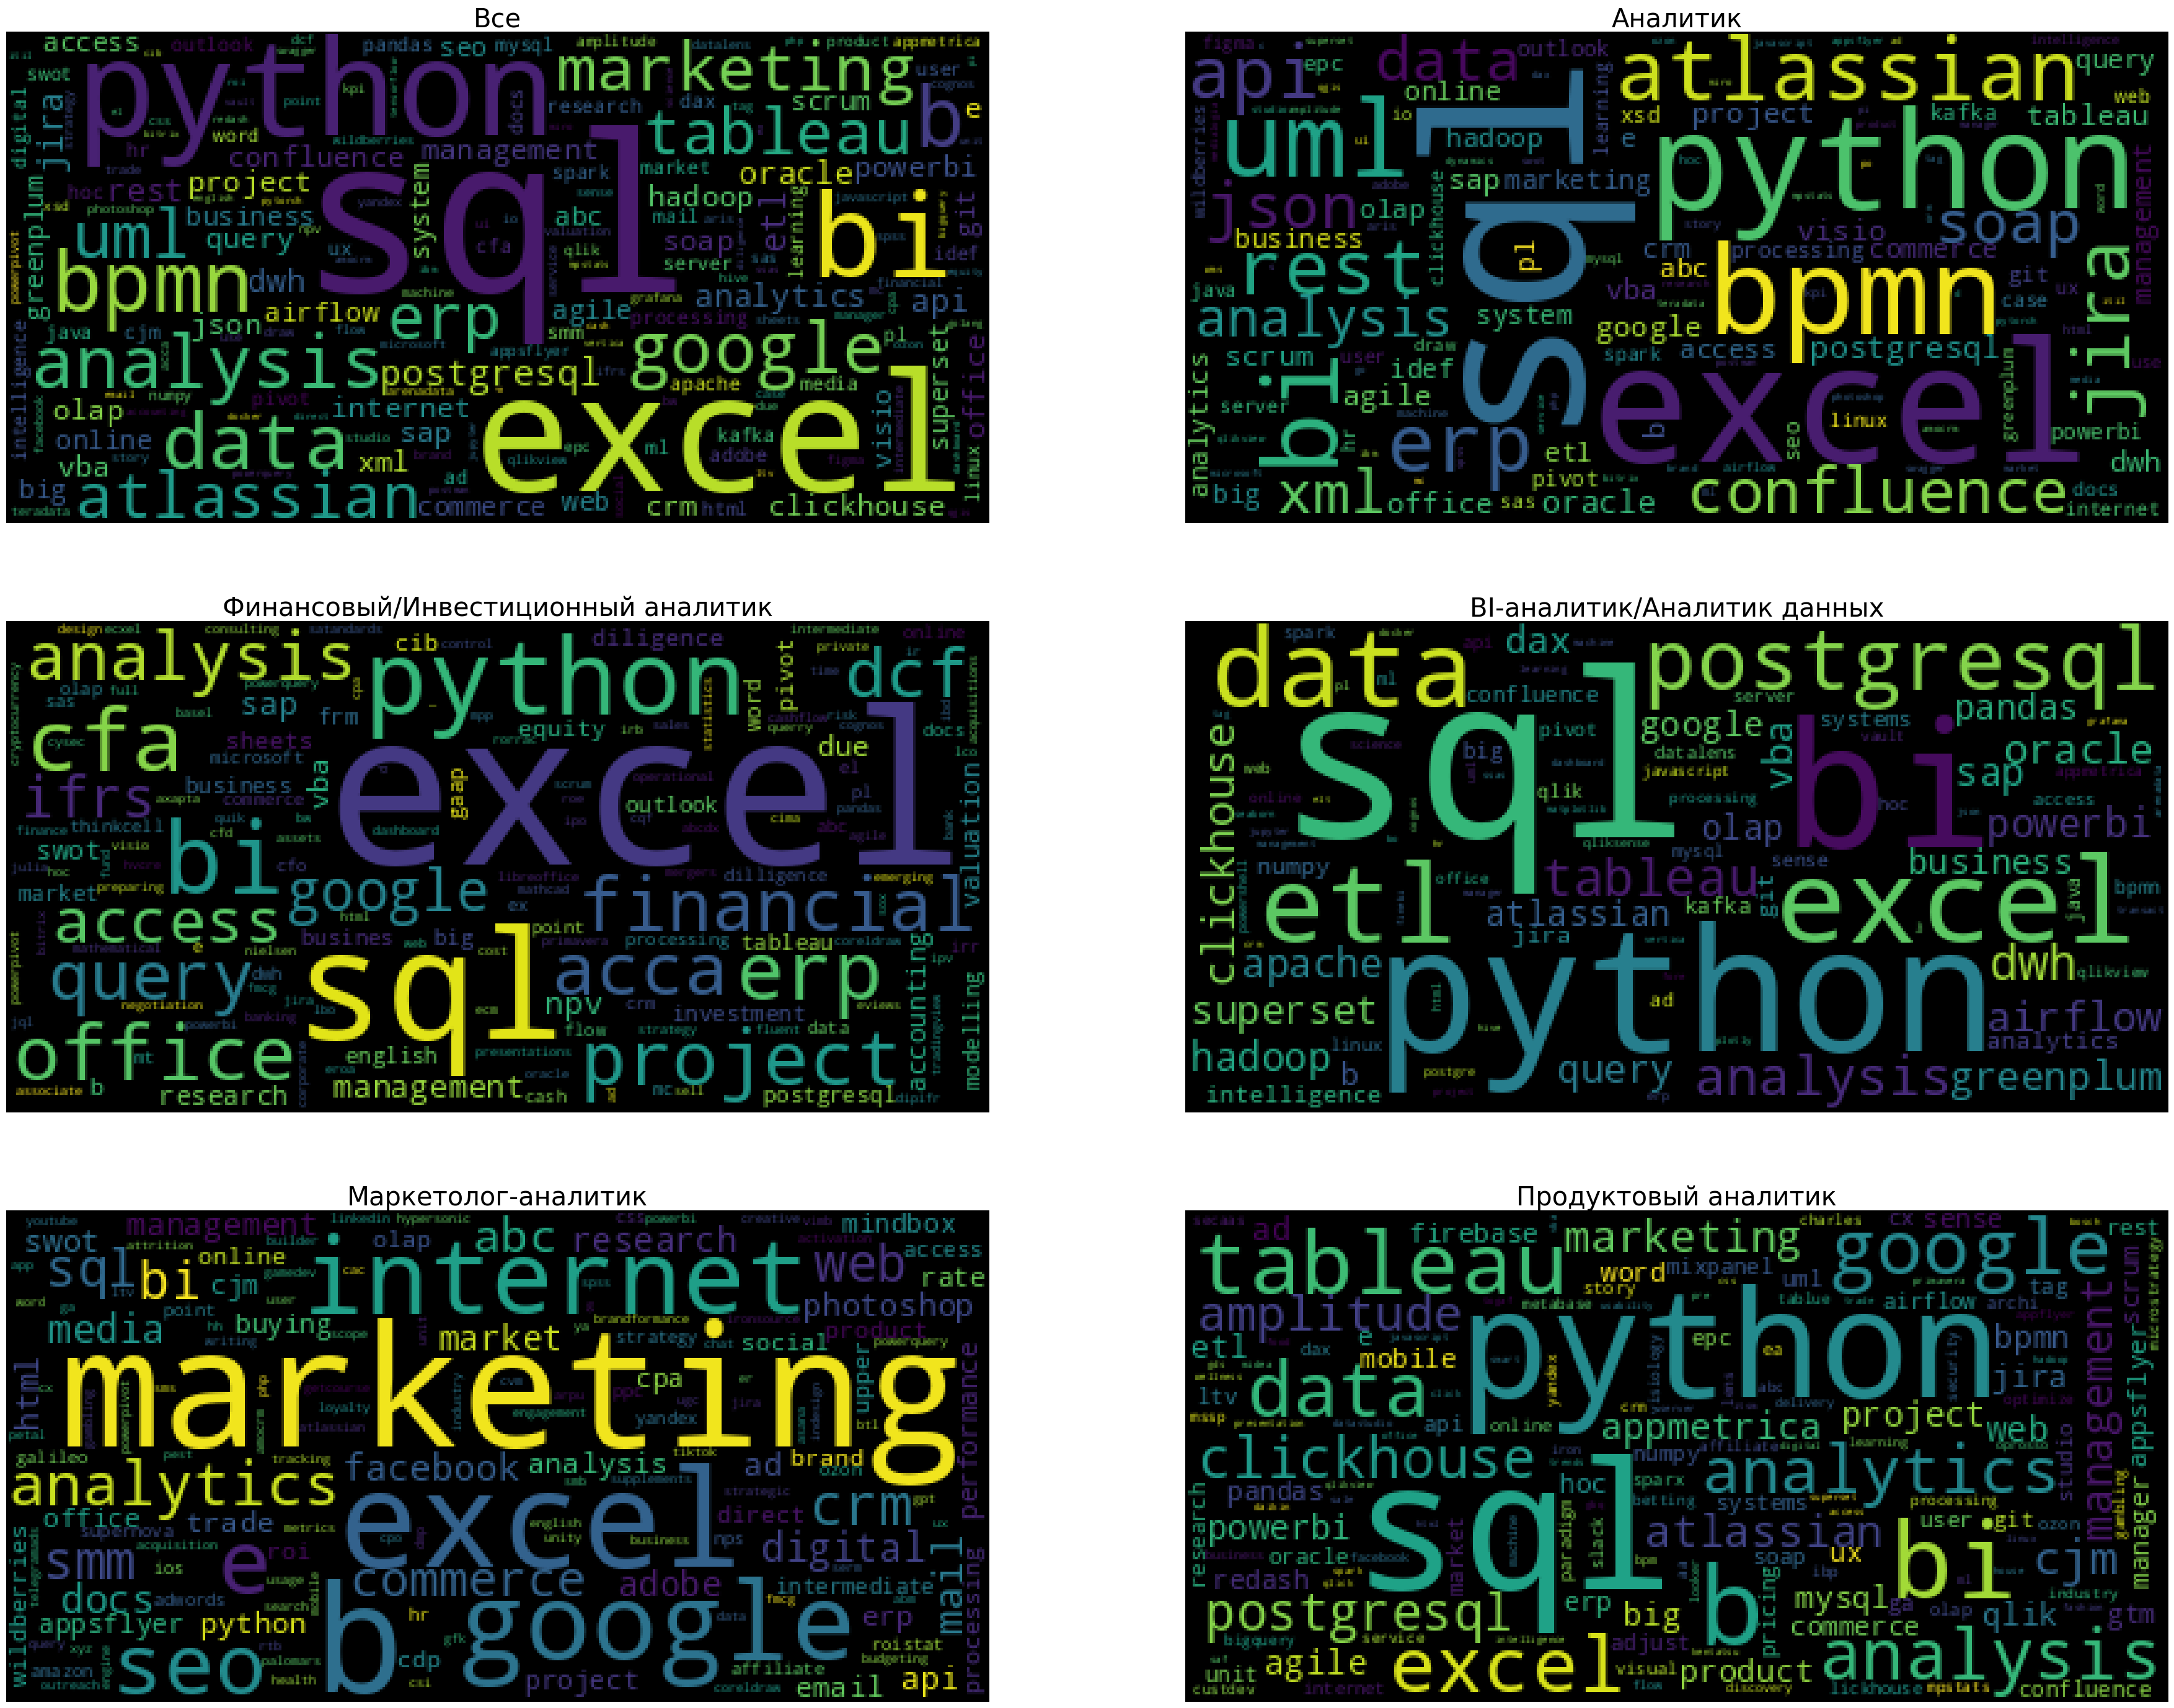

In [77]:
def clear_letter_words(word):
    return word not in ['analytical', 'asset', 'c', 'l', 'm', 'ms', 'p', 'power', 'powerpoint','skills']
    
def get_key_skill_cloud_text(key_skills):
    raw_skills = ','.join(key_skills.fillna('')).lower()
    latin_n_spaces_skills = sub(r'[^\x00-\x7f]|[0-9]|[–·\.,;:!?()-/\%\&\\«»•\+—`\']',r' ', raw_skills)
    skills = tokenize.word_tokenize(latin_n_spaces_skills)
    return ' '.join(filter(clear_letter_words, latin_n_spaces_skills.split(' ')))

key_skill_cloud_texts = {
    'analyst': get_key_skill_cloud_text(analyst_vacancies['key_skills']),
    'financial_n_investment_analyst': get_key_skill_cloud_text(financial_n_investment_analyst_vacancies['key_skills']),
    'bi_n_data_analyst': get_key_skill_cloud_text(bi_n_data_analyst_vacancies['key_skills']),
    'marketing_analyst': get_key_skill_cloud_text(marketing_analyst_vacancies['key_skills']),
    'product_analyst': get_key_skill_cloud_text(product_analyst_vacancies['key_skills']),
}

key_skills_collection = [
    {
        'name': 'Все',
        'text': ' '.join([
            key_skill_cloud_texts['analyst'],
            key_skill_cloud_texts['financial_n_investment_analyst'],
            key_skill_cloud_texts['bi_n_data_analyst'],
            key_skill_cloud_texts['marketing_analyst'],
            key_skill_cloud_texts['product_analyst']
        ])
    },
    {
        'name': 'Аналитик',
        'text': key_skill_cloud_texts['analyst']
    },
    {
        'name': 'Финансовый/Инвестиционный аналитик',
        'text': key_skill_cloud_texts['financial_n_investment_analyst']
    },
    {
        'name': 'BI-аналитик/Аналитик данных',
        'text': key_skill_cloud_texts['bi_n_data_analyst']
    },
    {
        'name': 'Маркетолог-аналитик',
        'text': key_skill_cloud_texts['marketing_analyst']
    },
    {
        'name': 'Продуктовый аналитик',
        'text': key_skill_cloud_texts['product_analyst']
    }
]

key_skills_figure = plt.figure(figsize=(45,35))
no_meta_variable = ''
for i, item in enumerate(key_skills_collection):
    key_skills_word_cloud = key_skills_figure.add_subplot(3,2,i+1)
    no_meta_variable = key_skills_word_cloud.axis('off')
    no_meta_variable = key_skills_word_cloud.set_title(item['name'], fontsize=30)
    no_meta_variable = key_skills_word_cloud.imshow(WordCloud(collocations=False).generate(item['text']))

В ключевых навыках для всех предпочитают указывать SQL. Выбивается Excel в финансовом/инвестиционном анализе. Предположу, что отличия связаны с меньшим энтузиазмом в заполнении ключевых навыков техническим стеком.

## Сравним облака слов описания и ключевых навыков
Можно сказать, что стек указанный в ключевых навыках и описании вакансии не повторяется на 100%.

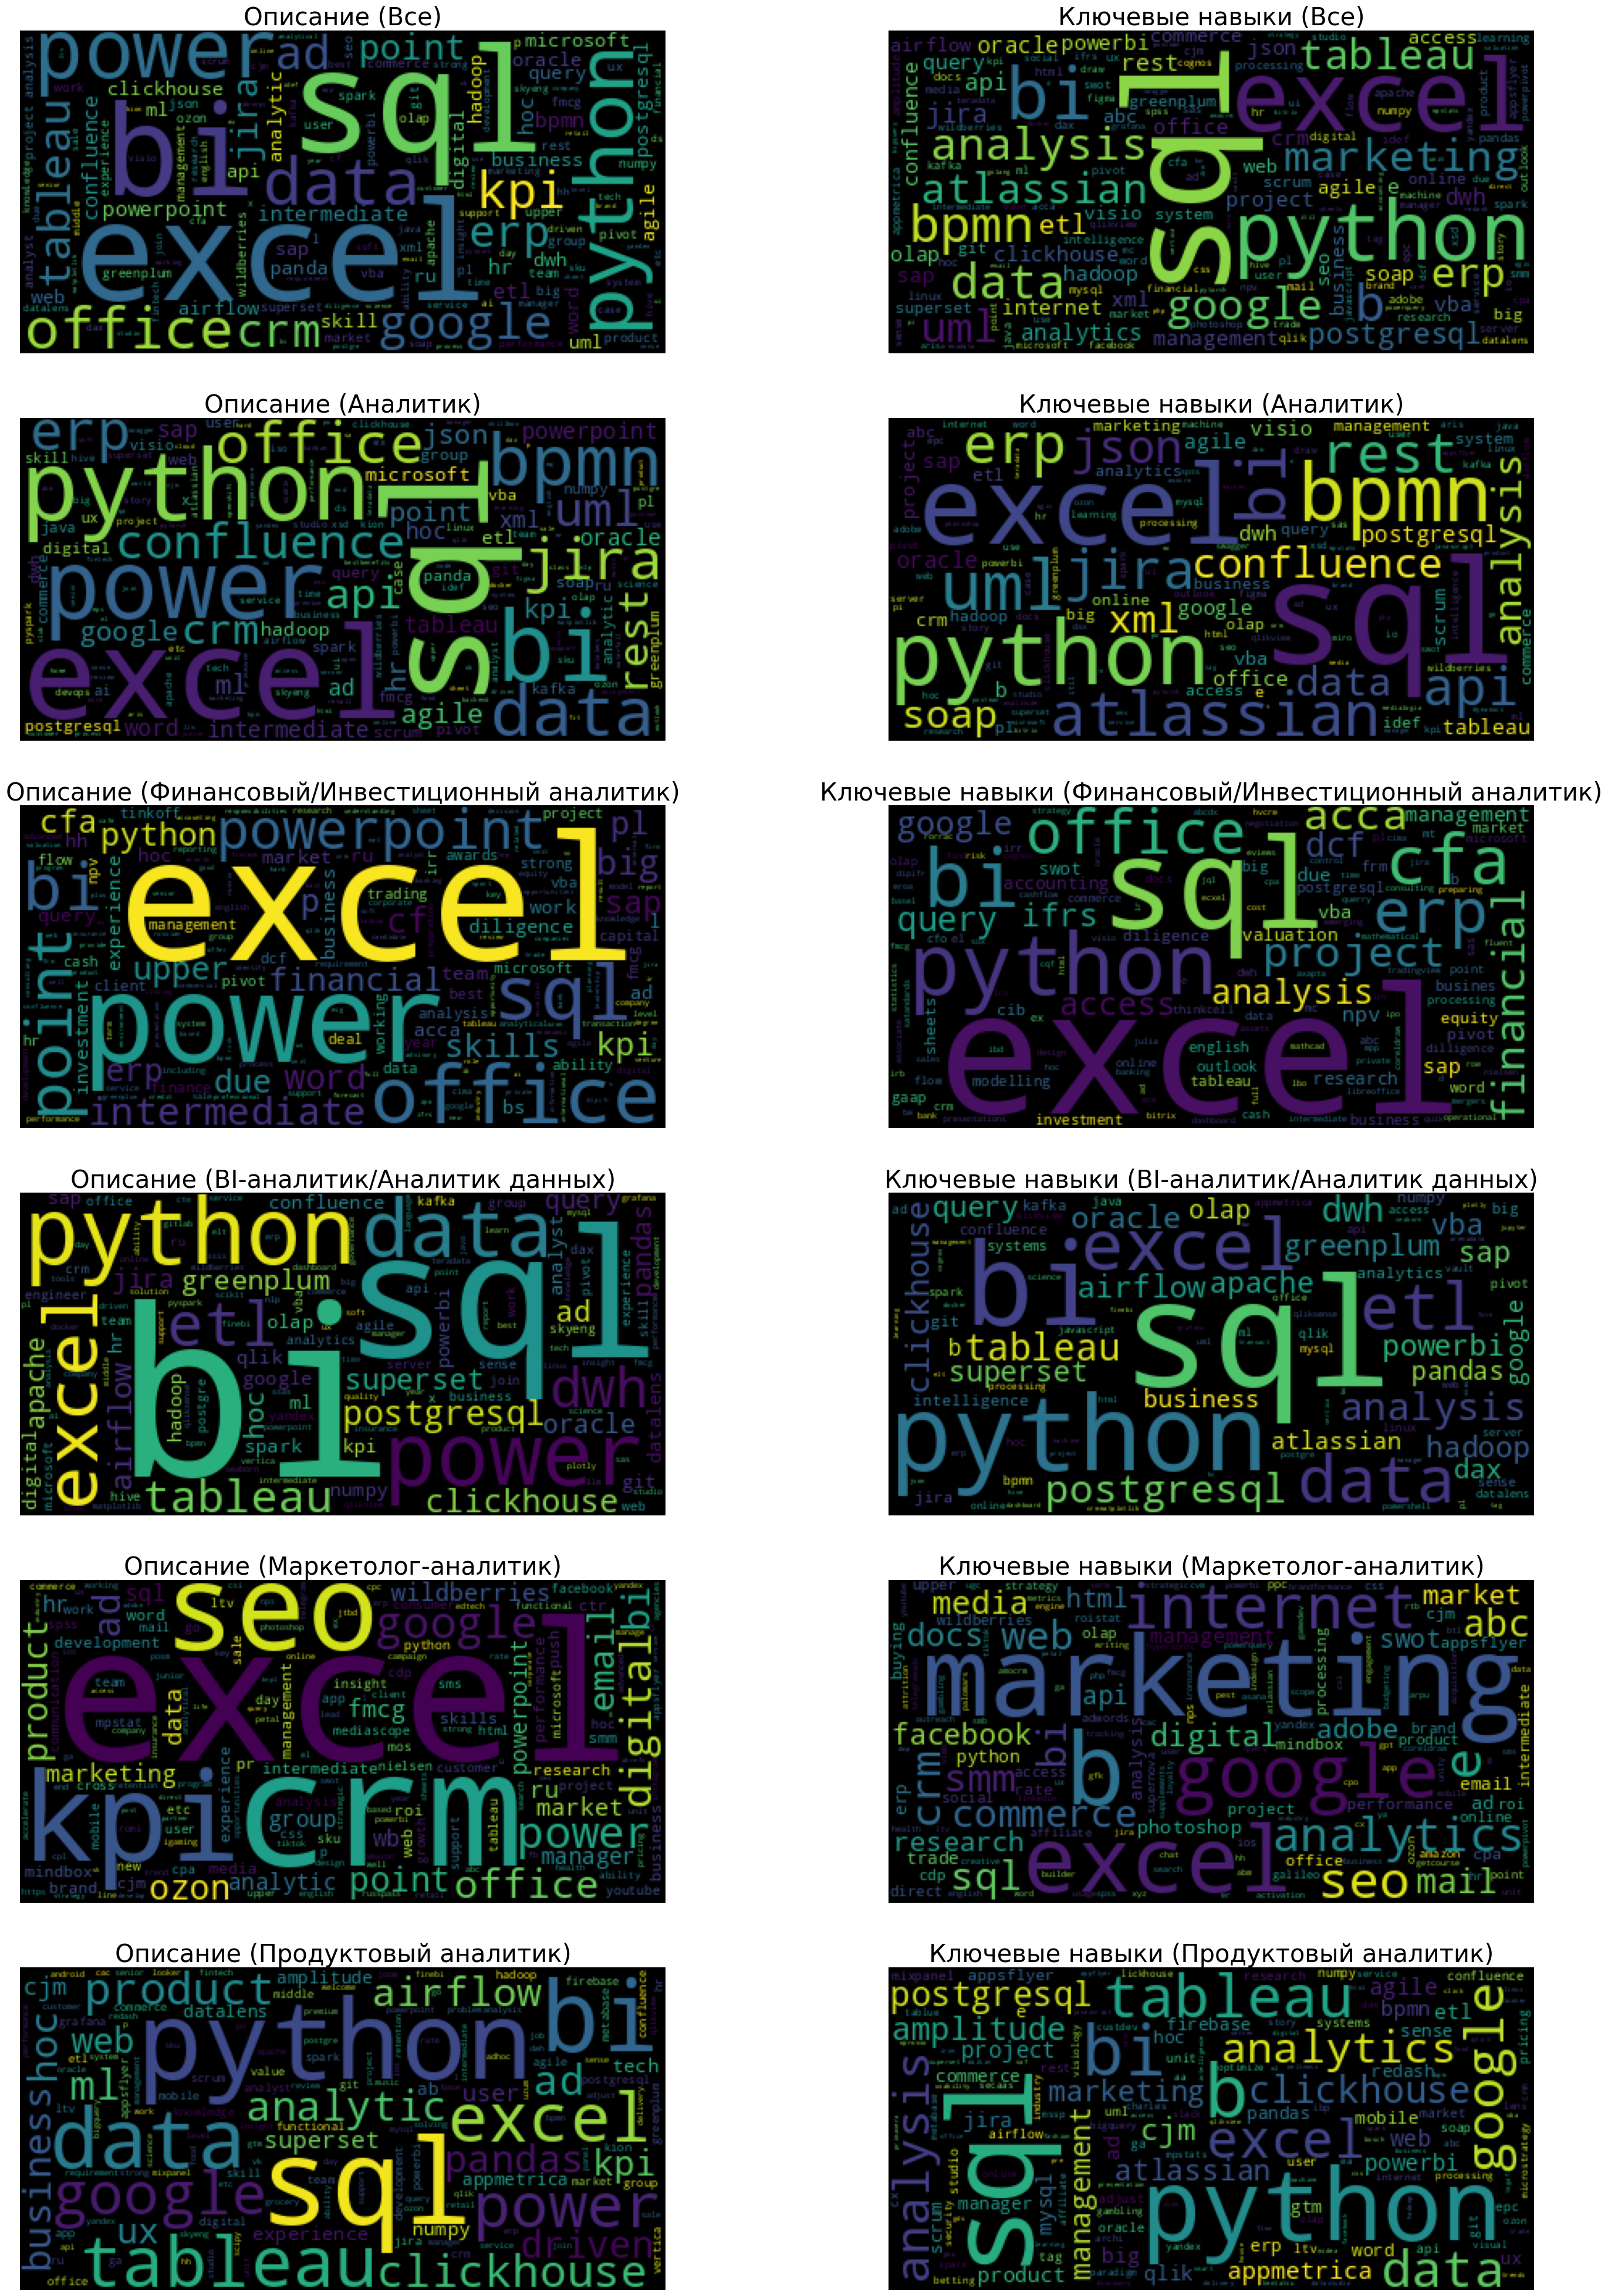

In [78]:
collection = []
key_skills_index = 0
description_index = 0
for i in range(12):
    if i % 2 == 0:
        item = description_collection[description_index].copy()
        item['name'] = f'Описание ({item["name"]})'
        collection.append(item)
        description_index+=1
    else:
        item = key_skills_collection[key_skills_index].copy()
        item['name'] = f'Ключевые навыки ({item["name"]})'
        collection.append(item)
        key_skills_index+=1

comparison_figure = plt.figure(figsize=(35,50))
no_meta_variable = ''
for i, item in enumerate(collection):
    comparison_word_cloud = comparison_figure.add_subplot(6,2,i+1)
    no_meta_variable = comparison_word_cloud.axis('off')
    no_meta_variable = comparison_word_cloud.set_title(item['name'], fontsize=30)
    no_meta_variable = comparison_word_cloud.imshow(WordCloud(collocations=False).generate(item['text']))

## Частота фраз в описании вакансии
Посмотрим на наиболее частые фразы и предложения, используемые в описании вакансий. Отдельно выведем результаты для финансовых и инвестиционных аналитиков.

In [80]:
from IPython.display import display_html
top_N = 10

analyst_vacancies_text = BeautifulSoup(analyst_vacancies.description.str.lower().str.replace(r',', '. ').str.cat(sep=' '), 'lxml').text
financial_n_investment_analyst_vacancies_text = BeautifulSoup(financial_n_investment_analyst_vacancies.description.str.lower().str.replace(r',', '. ').str.cat(sep=' '), 'lxml').text
bi_n_data_analyst_vacancies_text = BeautifulSoup(bi_n_data_analyst_vacancies.description.str.lower().str.replace(r',', '. ').str.cat(sep=' '), 'lxml').text
marketing_analyst_vacancies_text = BeautifulSoup(marketing_analyst_vacancies.description.str.lower().str.replace(r',', '. ').str.cat(sep=' '), 'lxml').text
product_analyst_vacancies_text = BeautifulSoup(product_analyst_vacancies.description.str.lower().str.replace(r',', '. ').str.cat(sep=' '), 'lxml').text
overall = ' '.join([
    analyst_vacancies_text,
    financial_n_investment_analyst_vacancies_text,
    bi_n_data_analyst_vacancies_text,
    marketing_analyst_vacancies_text,
    product_analyst_vacancies_text
])

stopwords_en = nltk.corpus.stopwords.words('english')
stopwords_ru = nltk.corpus.stopwords.words('russian')

def getPhrasesFrame(phrases):
    phrases = list(map(lambda w: w.strip('. '), phrases))
    words_except_stop_dist = nltk.FreqDist(w for w in phrases if w not in stopwords_en and w not in stopwords_ru and w not in ['ms', 'c', 'в т.ч', 'привет!', 'пожалуйста'])
    phrases_dist = nltk.FreqDist(words_except_stop_dist)
    return DataFrame(phrases_dist.most_common(top_N), columns=['Фраза', 'Частота'])

phrases = [
    {
        'name': 'Все',
        'phrases_frame': getPhrasesFrame(tokenize.sent_tokenize(overall))
    },
    {
        'name': 'Аналитик',
        'phrases_frame': getPhrasesFrame(tokenize.sent_tokenize(analyst_vacancies_text))
    },
    {
        'name': 'BI-аналитик/Аналитик данных',
        'phrases_frame': getPhrasesFrame(tokenize.sent_tokenize(bi_n_data_analyst_vacancies_text))
    },
    {
        'name': 'Маркетолог-аналитик',
        'phrases_frame': getPhrasesFrame(tokenize.sent_tokenize(marketing_analyst_vacancies_text))
    },
    {
        'name': 'Продуктовый аналитик',
        'phrases_frame': getPhrasesFrame(tokenize.sent_tokenize(product_analyst_vacancies_text))
    },
]

phrases_titles = []
phrases_tables = []
for phrase in phrases:
    phrases_titles.append(f'<td style="text-align: left">{phrase["name"]}</td>')
    phrases_tables.append(f'<td>{phrase["phrases_frame"].to_html()}</td>')

display_html(f'<table><tbody><tr>{"".join(phrases_titles)}</tr><tr>{"".join(phrases_tables)}</tr></table></br>', raw=True)

print('Финансовый/Инвестиционный аналитик')
display_html(getPhrasesFrame(tokenize.sent_tokenize(financial_n_investment_analyst_vacancies_text)).to_html(), raw=True)

Все Аналитик BI-аналитик/Аналитик данных Маркетолог-аналитик Продуктовый аналитик 
 
 
 
 Фраза 
 Частота 
 
 
 
 
 0 
 ответственность 
 180 
 
 
 1 
 сводные таблицы 
 131 
 
 
 2 
 коммуникабельность 
 119 
 
 
 3 
 excel 
 112 
 
 
 4 
 python 
 109 
 
 
 5 
 sql 
 102 
 
 
 6 
 tableau 
 100 
 
 
 7 
 тренинги 
 99 
 
 
 8 
 внимательность 
 92 
 
 
 9 
 инициативность 
 84 
 
 
 
 
 
 
 Фраза 
 Частота 
 
 
 
 
 0 
 ответственность 
 90 
 
 
 1 
 сводные таблицы 
 69 
 
 
 2 
 коммуникабельность 
 58 
 
 
 3 
 excel 
 57 
 
 
 4 
 анализ 
 51 
 
 
 5 
 тренинги 
 51 
 
 
 6 
 sql 
 46 
 
 
 7 
 внимательность 
 46 
 
 
 8 
 python 
 42 
 
 
 9 
 стрессоустойчивость 
 41 
 
 
 
 
 
 
 Фраза 
 Частота 
 
 
 
 
 0 
 python 
 40 
 
 
 1 
 tableau 
 40 
 
 
 2 
 power bi 
 35 
 
 
 3 
 sql 
 29 
 
 
 4 
 postgresql 
 26 
 
 
 5 
 airflow 
 26 
 
 
 6 
 greenplum 
 21 
 
 
 7 
 numpy 
 21 
 
 
 8 
 clickhouse 
 20 
 
 
 9 
 hadoop 
 19 
 
 
 
 
 
 
 Фраза 
 Частота 
 
 
 
 
 0 
 ответственность 
 23 
 
 
 1 
 коммуникабельность 
 19 
 
 
 2 
 инициативность 
 17 
 
 
 3 
 внимательность 
 16 
 
 
 4 
 excel 
 13 
 
 
 5 
 powerpoint 
 10 
 
 
 6 
 креативность 
 10 
 
 
 7 
 cpa 
 10 
 
 
 8 
 презентации 
 10 
 
 
 9 
 чай 
 9 
 
 
 
 
 
 
 Фраза 
 Частота 
 
 
 
 
 0 
 tableau 
 22 
 
 
 1 
 amplitude 
 18 
 
 
 2 
 python 
 16 
 
 
 3 
 numpy 
 14 
 
 
 4 
 firebase 
 13 
 
 
 5 
 airflow 
 12 
 
 
 6 
 superset 
 12 
 
 
 7 
 google analytics 
 12 
 
 
 8 
 datalens 
 11 
 
 
 9 
 например 
 11

Финансовый/Инвестиционный аналитик


Фраза 
 Частота 
 
 
 
 
 0 
 текстильщиков пр-кт 
 48 
 
 
 1 
 ответственность 
 46 
 
 
 2 
 сводные таблицы 
 34 
 
 
 3 
 word 
 32 
 
 
 4 
 коммуникабельность 
 29 
 
 
 5 
 excel 
 28 
 
 
 6 
 стрессоустойчивость 
 27 
 
 
 7 
 детский отдых и изучение английского языка; соц.программы по самым выгодным условиям от банка: кредит 
 26 
 
 
 8 
 автокредит 
 26 
 
 
 9 
 страхование и другие банковские продукты; финансовую поддержку от банка в различных жизненных ситуациях; участие в корпоративных забегах 
 26

Похоже вакансии по специальности Финансовый/Инвестиционный аналитик от Сбер не повторяются на 100% - поэтому не удалены при очистке дублей. Однако занимают существенную долю всех вакансий. Можно обратить внимание на отсутствие технических навыков в топе. При детальном изучении узнал, что финансовый аналитик и аналитик финансов - две разные специальности.

## Выводы
* Гипотеза 1 опровергнута - наиболее частые слова универсальны для описания вакансий,
* Гипотеза 2 подтверждена - Python и SQL преобладают в разделах BI-аналитик/Аналитик данных, Продуктовый аналитик. Следующий по популярности инструмент Excel наиболее часто встречается в разделе Финансовый/Инвестиционный аналитик,
* Для программиста, переезжающего в анализ данных, больше шансов найти работу по специальностям BI-аналитик/аналитик данных и Продуктовый аналитик на стеке Python/SQL,
* Анализ описания вакансии позволяет выявить специальные термины и инструменты с большим успехом, нежели анализ ключевых навыков,
* Повысить точность модели можно при фильтрации вакансий по грейду (джуниор, мидл, сеньор), как вариант - реализовать соответствующий фильтр в VacancyAggregator,